From [the RLRF paper](https://arxiv.org/pdf/2505.20793)
> We preprocess this data by rounding decimals to two
significant figures, removing XML headers, and filtering out samples with excessively long URLs or
embedded base64 images, which could lead the model to memorize irrelevant content

In [1]:
from datasets import load_dataset, Dataset

dataset = load_dataset("starvector/svg-stack", split="train")
dataset

Dataset({
    features: ['Filename', 'Svg'],
    num_rows: 2169710
})

In [2]:
dataset[1230]

{'Filename': '0bf622d38312a560d831a6005ff2c326f7e7771d.svg',
 'Svg': '<svg role="img" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path d="M10.040 0.041 C 6.371 0.422,3.109 2.637,1.500 5.840 C 0.240 8.348,0.055 11.425,1.007 14.060 C 2.191 17.338,5.083 19.881,8.580 20.719 C 9.519 20.944,9.850 20.980,10.980 20.980 C 12.084 20.980,12.503 20.937,13.327 20.744 L 13.714 20.653 13.944 21.025 C 15.161 22.991,16.605 23.910,18.600 23.988 C 20.479 24.061,21.924 23.365,22.806 21.961 C 23.276 21.212,23.600 20.091,23.600 19.211 L 23.600 19.000 22.821 19.000 L 22.042 19.000 22.018 19.110 C 21.925 19.547,21.677 20.009,21.410 20.244 C 20.810 20.770,19.746 20.760,18.954 20.219 C 18.632 19.999,18.210 19.563,17.859 19.088 L 17.602 18.740 17.751 18.620 C 19.502 17.209,20.737 15.306,21.281 13.180 C 21.542 12.159,21.580 11.817,21.579 10.500 C 21.578 9.482,21.567 9.277,21.488 8.824 C 21.314 7.824,21.063 6.989,20.685 6.160 C 19.206 2.912,16.117 0.642,12.432 0.098 C 11.940 0.025,10.517 -0.009,10.040 

In [3]:
from PIL import Image
import os
import io
# stupid cairo
os.environ["DYLD_LIBRARY_PATH"] = "/opt/homebrew/lib:" + os.environ.get("DYLD_LIBRARY_PATH", "")

from svg_rlrf_reward import rasterize_svg

image_bytes, tree, (width, height) = rasterize_svg(dataset[1230]["Svg"])
Image.open(io.BytesIO(image_bytes))

In [4]:
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

def rasterize(example):
    try:
        img_bytes, tree, (width, height) = rasterize_svg(example["Svg"])
        return {"image": Image.open(io.BytesIO(img_bytes)), "width": width, "height": height}
    except Exception:
        return {"image": None, "tree": None, "width": None, "height": None}
    
subset = dataset.select(range(1000))
subset = subset.map(rasterize, with_indices=False)

Train size: 1952739
Test size: 216971


In [5]:
subset["image"][123]


In [6]:
subset = subset.filter(lambda x: x["image"] is not None)
print(f"{len(subset)}/{1000} images rendered successfully")
subset

775/1000 images rendered successfully


Dataset({
    features: ['Filename', 'Svg', 'image', 'width', 'height'],
    num_rows: 775
})

In [ ]:
import subprocess
import tempfile
import os

from datasets import Value

def svgo_batch(svg_texts, precision: int = 2, pretty: bool = False):
    """
    Optimize a batch of SVGs by writing them to a temp directory and running svgo on the directory.
    Returns a list of optimized SVG strings in the same order.
    If the batch fails, runs on individual files so that only the bad files are excluded.
    Uses the same input/output directories for individual files.
    """
    def filename(i: int) -> str:
        return f"{i:06d}.svg"

    svgo_args = ["--precision", str(precision)]
    if pretty:
        svgo_args.append("--pretty")

    with tempfile.TemporaryDirectory() as tmpdir:
        input_dir = os.path.join(tmpdir, "input")
        output_dir = os.path.join(tmpdir, "output")
        os.makedirs(input_dir, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)
        # Write each SVG to a file in the input directory
        for i, svg in enumerate(svg_texts):
            fname = filename(i)
            with open(os.path.join(input_dir, fname), "w", encoding="utf-8") as f:
                f.write(svg)
        # Run svgo on the directory

        cmd = [
            "npx", "-y", "svgo",
            "-f", input_dir,
            "-o", output_dir,
            *svgo_args,
        ]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        optimized_svgs = []
        batch_failed = proc.returncode != 0
        if batch_failed:
            print(f"SVGO on batch failed: {proc.stderr.decode('utf-8')}, included files: {[os.path.join(input_dir, x) for x in os.listdir(input_dir)]}")
            # Try to optimize each SVG individually, reusing the same input/output dirs
            for i, svg in enumerate(svg_texts):
                fname = filename(i)
                input_path = os.path.join(input_dir, fname)
                output_path = os.path.join(output_dir, fname)
                single_cmd = [
                    "npx", "-y", "svgo",
                    "-i", input_path,
                    "-o", output_path,
                    *svgo_args,
                ]
                single_proc = subprocess.run(single_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                if single_proc.returncode != 0 or not os.path.exists(output_path):
                    print(
                        f"SVGO failed on single file {input_path}\n\n{svg_texts[i]}\n\n{single_proc.stderr.decode('utf-8')}"
                    )
                    optimized_svgs.append(svg)
                else:
                    with open(output_path, "r", encoding="utf-8") as f:
                        optimized_svgs.append(f.read())
        else:
            # Read optimized SVGs in the same order using out_fnames
            for i in range(len(svg_texts)):
                out_path = os.path.join(output_dir, filename(i))
                if not os.path.exists(out_path):
                    print(f"SVGO failed on {out_path}")
                    # If svgo failed to write output, fallback to original
                    optimized_svgs.append(svg_texts[i])
                else:
                    with open(out_path, "r", encoding="utf-8") as f:
                        optimized_svgs.append(f.read())
        return optimized_svgs

original_svg = dataset[1230]["Svg"]
optimized_svg = svgo_batch([original_svg])[0]
print(f"Saved {len(original_svg) - len(optimized_svg)} bytes ({((len(original_svg) - len(optimized_svg)) / len(original_svg) * 100):.2f}%) by optimizing")

def add_svg_sizes_batch(batch, **kwargs):
    optimized_svgs = svgo_batch(batch["Svg"], **kwargs)
    metas = []
    for original_svg, optimized_svg in zip(batch["Svg"], optimized_svgs):
        metas.append({
            "original_size": len(original_svg),
            "optimized_size": len(optimized_svg),
            "bytes_saved": len(original_svg) - len(optimized_svg),
            "percent_saved": ((len(original_svg) - len(optimized_svg)) / len(original_svg) * 100) if len(original_svg) > 0 else 0
        })
    return {"Svg": optimized_svgs, "meta": metas}

features = subset.features.copy()
features["meta"] = {
    "original_size": Value("int32"),
    "optimized_size": Value("int32"),
    "bytes_saved": Value("int32"),
    "percent_saved": Value("float32"),
}

# Use batch mapping for speed, now using file-based batch optimization
subset_optimized = subset.map(
    add_svg_sizes_batch,
    batched=True,
    batch_size=16,
    features=features,
    num_proc=8,
)
subset_optimized


Saved 916 bytes (48.59%) by optimizing


Map (num_proc=8):   0%|          | 0/775 [00:00<?, ? examples/s]

Dataset({
    features: ['Filename', 'Svg', 'image', 'width', 'height', 'meta'],
    num_rows: 775
})

In [16]:
subset_optimized[0]["meta"]

{'original_size': 1165,
 'optimized_size': 419,
 'bytes_saved': 746,
 'percent_saved': 64.03433227539062}

770/775 images are free of base64 images
Examples with base64 images (showing up to 5):
----------------------------------------------------------------------------------------------------
Filename: eeb61ae6c3e61554d6b2808412dff90704f4ca10.svg
SVG: <svg id="icon_thunderstorm_day" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="103" height="69.031" viewBox="0 0 103 69.031">
  <metadata><?xpacket begin="﻿" id="W5M0MpCehiHzreSzNTczkc9d"?>
<x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="Adobe XMP Core 5.6-c138 79.159824, 2016/09/14-01:09:01        ">
   <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
      <rdf:Description rdf:about=""/>
   </rdf:RDF>
</x:xmpmeta>
                                                                                                    
                                                                                                    
                                                                             
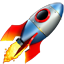
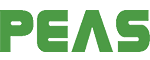
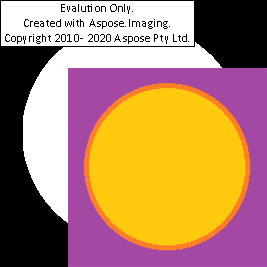

In [15]:
import re

def no_base64_image(example):
    svg = example.get("Svg", "")
    # Look for <image ... xlink:href="data:image/..." or href="data:image/..."
    return not re.search(r'(xlink:href|href)\s*=\s*["\']data:image\/', svg)

subset_no_base64 = subset.filter(no_base64_image)
subset_no_base64

print(f"{len(subset_no_base64)}/{len(subset)} images are free of base64 images")

# Print some examples that fail the check
failed_examples = [ex for ex in subset if not no_base64_image(ex)]
print("Examples with base64 images (showing up to 5):")
for ex in failed_examples[:5]:
    print("-"*100)
    print(f"Filename: {ex.get('Filename', 'N/A')}")
    print(f"SVG: {ex.get('Svg', '')}\n")